# Neighborhood Project

## CMPINF0999 Final

### Yifeng Qiu and James Fenn

In [88]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
# basic arrest / "people" data; may depend on population of each neighborhood, unreliable unless scaled accordingly

# download 311 data from https://data.wprdc.org/dataset/311-data
data311 = pd.read_csv("https://data.wprdc.org/datastore/dump/76fda9d0-69be-4dd5-8108-0de7907fc5a4", low_memory=False)

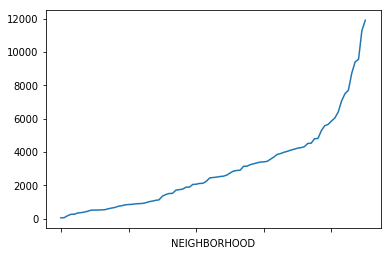

In [145]:
# plot amount of 311 calls per neighborhood in a line
data311.groupby("NEIGHBORHOOD").size().sort_values().plot(kind='line')

This shows us that _most_ neighborhoods get less than 6,000 calls, while there are just a few outliers going up to 12,000. We might want to stay away from these neighborhoods... or do we? The amount of 311 calls that each neighborhood recieves are likely dependent upon how many people are in that neighborhood or how big the neighborhood is.

In [146]:
# create DataFrame of quantity 311 calls indexed by neighborhood
mData311 = pd.DataFrame(data311.groupby("NEIGHBORHOOD").size(), columns=["calls"])
# add "mostType" column containing the most common request type of each neighborhood
mData311["mostType"] = data311.groupby(["NEIGHBORHOOD"]).agg(lambda x: x["REQUEST_TYPE"].value_counts().index[0])["REQUEST_TYPE"]

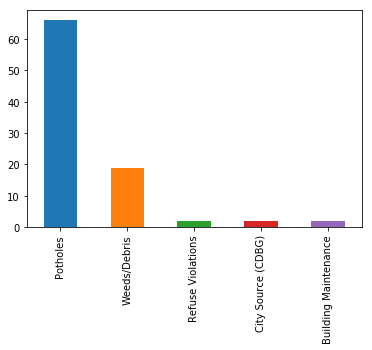

In [147]:
# plot the most common "most reported" request types
mData311["mostType"].value_counts().plot(kind='bar')

This shows us that the most common 311 calls are for potholes and Weed/Debris. We can use this to show that the most significant aspect of Pittsburgh neighborhoods that people find annoying are the potholes. In this case, to "narrow down" our list of potential best neighborhoods, we can look for a set of neighborhoods with the least amount of potholes.

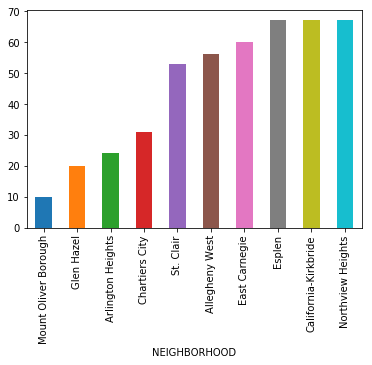

In [148]:
# create a new column containing the amount of pothole reports
mData311["potholes"] = data311.groupby(["NEIGHBORHOOD"]).agg(lambda x: len(x.loc[x["REQUEST_TYPE"] == "Potholes"]))["REQUEST_TYPE"]
# sort by potholes column, get smallest 10 neighborhoods, and graph
mData311["potholes"].sort_values(ascending=True).head(10).plot(kind='bar')

This data seems to indicate that Mount Oliver Borough has the least amount of potholes, however this data could easily be influenced by the size of the neighborhood. For all I know, Mount Oliver Borough could contain a single road that has 10 potholes on it. That wouldn't be a very good neighborhood compared to, say Esplen, which could have 68 potholes spread out over 200 roads. Similar to the initial line graph of the total amount of calls, let's graph the amount of pothole calls over all of the neigborhoods.

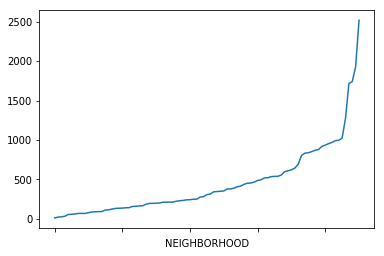

In [149]:
mData311["potholes"].sort_values(ascending=True).plot(kind='line')

This graph seems similar to the initial graph of the quantity of all 311 calls per neighborhood, but it isn't quite the same. Instead of measuring only the quantity of pothole reports per neighborhood, it might yield more accurate results to scale them based on the total reports in that neighborhood; in other words, find the neighborhood in which the percentage of pothole reports is the least.

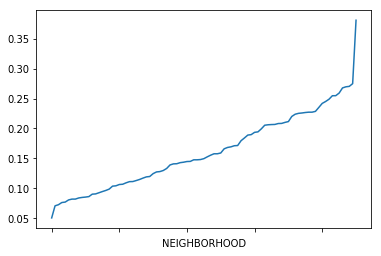

In [150]:
# create a new column, "potholePercentage", containing the percentage of the reports in each neighborhood that are potholes
mData311["potholePercentage"] = data311.groupby(["NEIGHBORHOOD"]).agg(lambda x: len(x.loc[x["REQUEST_TYPE"] == "Potholes"]) / len(x))["REQUEST_TYPE"]
# graph the result
mData311["potholePercentage"].sort_values(ascending=True).plot(kind='line')

Now **this** graph looks a little more linear. This we can use. Let's get the neighborhoods for which less than 10% of the reports are about potholes.

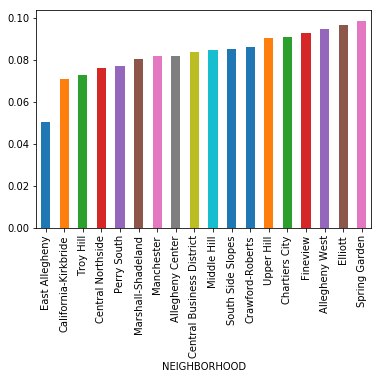

In [224]:
mData311["potholePercentage"].sort_values(ascending=True).loc[mData311["potholePercentage"] < 0.1].plot(kind='bar')

This has given us a more accurate list of the neighborhoods with the least _percentage_ of potholes, as opposed to quantity. It may not be perfectly accurate, as the total amount of reports doesn't necessarily indicate the size of the neighborhood, and a lack of pothole reports may indicate that other types of reports are more prevalent, but it can at least get us on the right track. Let's take the 10 "best" neighborhoods in this aspect and measure them against some other attributes.

In [179]:
# information about the environment / physical aspects of each neighborhood
# how many playgrounds are there, how many trees there are, what the air quality is, etc

# download trees data from https://data.wprdc.org/dataset/city-trees
dataTrees = pd.read_csv("https://data.wprdc.org/datastore/dump/1515a93c-73e3-4425-9b35-1cd11b2196da", low_memory=False)

Let's assume that a neighborhood is better if it has more trees. At this point we are completely disregarding the size of the neighborhood. Hopefully it won't have much effect on the result.

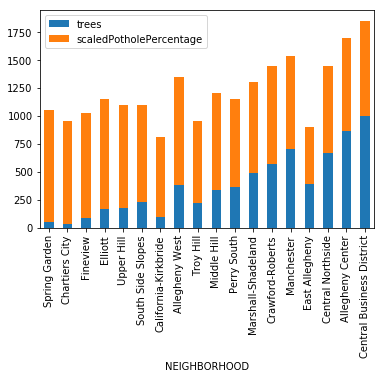

In [223]:
# take the neighborhoods with less than 10% pothole reports to measure against trees
mDataTrees = mData311.loc[mData311["potholePercentage"] < 0.1].copy()
# measure the quantity of trees in each neighborhood
mDataTrees["trees"] = dataTrees.loc[dataTrees["neighborhood"].isin(mDataTrees.index)].groupby(["neighborhood"]).agg(lambda x: len(x))["id"]
# scale the pothole percentage to match the magnitude of the tree quantity
mDataTrees["scaledPotholePercentage"] = (mDataTrees["potholePercentage"] / mDataTrees["potholePercentage"].sort_values(ascending=False)[0]) * mDataTrees["trees"].sort_values(ascending=False)[0]
# add "rank" column consisting of the trees (good) minus the potholes (bad)
mDataTrees["rank"] = mDataTrees["trees"] - mDataTrees["scaledPotholePercentage"]
# output tree quantity and pothole percentage side by side
mDataTrees.sort_values("rank")[["trees", "scaledPotholePercentage"]].plot(kind='bar', stacked=True)

Based on this data, the Central Business District has the best tree-to-pothole ratio, making it the best neighborhood by this measurement. East Allegheny, which _was_ winning in the initial pothole measurement, lost here because it has a smaller amount of trees, so it is likely that another factor was affecting it.